# Make a theta-square plot

This is a basic example to analyze some events and make a $\Theta^2$ plot

In [1]:
%matplotlib inline

In [2]:
from astropy import units as u
from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates import SkyCoord, AltAz

import matplotlib.pyplot as plt
import numpy as np

from ctapipe.io import EventSource
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from ctapipe.reco import HillasReconstructor
from ctapipe.image import hillas_parameters, tailcuts_clean
from ctapipe.utils import datasets

Get source events in MC dataset. Here we stop at 10 events, just to make this example run fast, but for real use, one would need more statistics. 

In [3]:
filename = datasets.get_dataset_path("gamma_test_large.simtel.gz")
source = EventSource(filename, allowed_tels={1, 2, 3, 4}, max_events=10)
calib = CameraCalibrator(subarray=source.subarray)
horizon_frame = AltAz()

In [4]:
off_angles = []
for event in source:

    # calibrating the event
    calib(event)
    
    hillas_params = {}
    
    # pointing direction of the telescopes
    telescope_pointings = {}
    
    subarray = source.subarray
    
    # get hillas params for each event in different telescopes
    for tel_id in event.dl0.tel.keys():

        # telescope pointing direction
        telescope_pointings[tel_id] = SkyCoord(
            alt=event.pointing.tel[tel_id].altitude,
            az=event.pointing.tel[tel_id].azimuth,
            frame=horizon_frame
        )  

        # Camera Geometry required for hillas parametrization
        camgeom = subarray.tel[tel_id].camera.geometry

        # note the [0] is for channel 0 which is high-gain channel
        image = event.dl1.tel[tel_id].image

        # Cleaning  of the image
        cleaned_image = image
        # create a clean mask of pixels above the threshold
        cleanmask = tailcuts_clean(
            camgeom, image, picture_thresh=10, boundary_thresh=5
        )
        # set all rejected pixels to zero
        cleaned_image[~cleanmask] = 0

        # Calulate hillas parameters
        # It fails for empty pixels
        try:
            hillas = hillas_parameters(camgeom, cleaned_image)
        except Exception as e:
            print(e)
            pass
        
        if hillas.width.value > 0:
            hillas_params[tel_id] = hillas

    if len(hillas_params) < 2:
        continue

    array_pointing = SkyCoord(
        az=event.pointing.array_azimuth,
        alt=event.pointing.array_altitude,
        frame=horizon_frame
    )
    
    reco = HillasReconstructor(event=event)
    reco_result = reco.predict(
        hillas_params, source.subarray,
        array_pointing, telescope_pointings,
    )

    # get angular offset between reconstructed shower direction and MC
    # generated shower direction
    mcshower = event.simulation.shower
    off_angle = angular_separation(mcshower.az, mcshower.alt, reco_result.az, reco_result.alt)

    # Appending all estimated off angles
    off_angles.append(off_angle.to(u.deg).value)

calculate theta square for angles which are not nan

In [5]:
off_angles = np.array(off_angles)
thetasquare = off_angles[np.isfinite(off_angles)]**2

## Plot the results

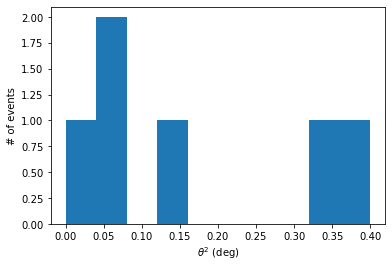

In [6]:
plt.hist(thetasquare, bins=10, range=[0,0.4])
plt.xlabel(r'$\theta^2$ (deg)')
plt.ylabel("# of events")
plt.show()

again, this plot is not beautiful since we have such low stats